# Potencial no espaço causado por dois condutores via mapeamento conforme

Date: 2021-01-08  
Author: Pedro H. N. Vieira  
Categories: mapeamento conforme, potencial, campo elétrico  
Tags: julia, mapeamento conforme, potencial, campo elétrico  
<!--eofm-->

Determinar o potencial elétrico no espaço dados dois condutores infinitos, cilíndricos e paralelos, $C_1$ e $C_2 $que estejam no potencial $V_1$ e $V_2$, respectivamente.

## Equação a ser resolvida
A equação a ser resolvida é a de Laplace no plano complexo ($z = x + iy$, onde $i = \sqrt{-1}$ é a unidade
imaginária) excluindo-se as regiões dentro dos condutores.

$$
\nabla^2 v(z) = 0
$$

Sejam dois círculos, $C_1$ e $C_2$ com raio $R_1$ e $R_2$ , respectivamente, tal que $R_1 \ge R_2$ . Assuma ainda que $C_1$ está centrado na origem do plano complexo e $C_2$ centrado sobre o eixo Real no ponto $h$ tal que $h > R_1 + R_2$. A região $C^c_1 \cap C^c_2$ pode ser mapeada em um anel centrado na origem encadeando-se
[Transformações de Möbius](https://en.wikipedia.org/wiki/M%C3%B6bius_transformation).

Desta forma, podemos resolver o problema no domínio transformado com uma geometria mais simples e obter a solução no domínio original através da transformação inversa.

## Preparar o ambiente computacional
Usado Julia v1.6.1

In [1]:
using LinearAlgebra
using NLsolve
using Polynomials
using Statistics
using ForwardDiff
using Plots
pyplot()
import PyPlot  # por causa do streamplot

const ϵ0 = 8.8541878176e-12  # permeabilidade elétrica do espaço livre

8.8541878176e-12

In [2]:
R1 = 2.2  # raio do condutor 1
R2 = 1.7  # raio do condutor 2
h = 8  # separação entre os condutores
@assert R1 >= R2 && h > R1 + R2  # teste de sanidade das hipóteses
v1 = 1/2  # potencial no condutor 1
v2 = -1/2  # potencial no condutor 2
n = 100  # "resolução" dos gráficos

100

## Algoritmo
Encontre os parâmetros $a, b, c, d$ da Transformação de Möbius (pode ser via [fórmula do determinante
explícito](https://en.wikipedia.org/wiki/M%C3%B6bius_transformation#Explicit_determinant_formula)) que mapeie o círculo $C_1$ numa reta sobre o eixo imaginário ($\boldsymbol z \to \boldsymbol w$).

$$
\boldsymbol z = \begin{bmatrix}
-i R_1, i R_1, -R_1
\end{bmatrix}
$$

$$
\boldsymbol w = \begin{bmatrix}
-i, i, 0
\end{bmatrix}
$$

Essa transformação é:

$$
f(z) = \frac{az + b}{cz + d}
$$

$$a=\det \begin{pmatrix} z_1w_1 & w_1 & 1 \\   z_2w_2 & w_2 & 1 \\   z_3w_3 & w_3 & 1 \end{pmatrix}\,$$

$$b=\det \begin{pmatrix} z_1w_1 & z_1 & w_1 \\   z_2w_2 & z_2 & w_2 \\   z_3w_3 & z_3 & w_3 \end{pmatrix}\, $$

$$c=\det \begin{pmatrix} z_1 & w_1 & 1 \\   z_2 & w_2 & 1 \\   z_3 & w_3 & 1 \end{pmatrix}\, $$

$$d=\det \begin{pmatrix} z_1w_1 & z_1 & 1 \\  z_2w_2 & z_2 & 1 \\   z_3w_3 & z_3 & 1 \end{pmatrix}$$

Mova ambos linha e círculo resultantes por ($-p$) tal que o círculo de raio $r_w$ esteja centrado na origem. As variáveis $p$ e $r_w$ satisfazem:

$$
\begin{aligned}
|w_1|^2 - 2 \Re(w_1 \bar p) + |p|^2 - r_w^2 &= \\
|w_2|^2 - 2 \Re(w_2 \bar p) + |p|^2 - r_w^2 &= 0
\end{aligned}
$$

Onde $w_1$ e $w_2$ são pontos sobre o círculo. Esta transformação é:

$$g(z) = z - p$$

Agora encontre $\xi_1$ e $\xi_2$ (pontos simétricos a ambos linha e círculo, zeros da equação seguinte) que transforme a linha num círculo centrado na origem enquanto preserva o centro do outro círculo na origem (também).

$$ \xi^2 + 2 p \xi + r_w^2 = 0 $$

Esta transformação é:

$$ h(z) = \frac{z - \xi_1}{z - \xi_2} $$

A transformação composta é dada por:

$$ T(z) = h \circ g \circ f (z) $$

$$
T(z) = \frac{R_1 (p + \xi_1 + 1) - z(p + \xi_2 + 1)}{R_1 (p + \xi_1 - 1) - z(p + \xi_2 - 1)}
$$

Agora o problema do potencial pode ser resolvido no anel. Veja, por exemplo, [*Conformal Mapping and Bipolar Coordinate for Eccentric Laplace Problems*](http://msvlab.hre.ntou.edu.tw/grades/bem(2008)/caee2009-bipolar.pdf).

A transformação inversa é dada por:

$$
T^{-1}(z) = R_1 \frac{(p + \xi_1 + 1) - z (p + \xi_2 + 1)}{(p + \xi_1 - 1) - z (p + \xi_2 - 1)}
$$

In [3]:
function find_trans(r1, r2, h, n=10)
    """
    Acha a transformação que mapeia a área disjunta de dois discos de raios
    r1 e r2 num anel centrado na origem. Considera-se r1 ≥ r2 e que o disco
    de raio r1 está centrado na origem e o disco de raio r2 centrado no ponto h.

    Retorna
    -------
        T : a transformação T
        Ti : a transformação inversa
        params : tupla dos parâmetros (p, ξ1, ξ2)
    """
    if r1 < r2
        throw(ArgumentError("r1 < r2"))
    end
    if h < r1 + r2
        throw(ArgumentError("h < r1 + r2"))
    end
    θ = range(0, 2π, length=n)
    z1 = @. r1*(cos(θ) + 1im*sin(θ))
    z2 = @. r2*(cos(θ) + 1im*sin(θ)) + h
    # transforma o círculo maior numa linha sobre o eixo imaginário
    f(z) = (r1 + z)/(r1 - z)
    # centrar o círculo C2 transformado na origem
    w1 = f(z2[1])
    w2 = f(z2[cld(n,2)])
    function f!(F, x)
        F[1] = abs(w1)^2 - 2*real(w1*conj(x[1])) + abs(x[1])^2 - x[2]^2
        F[2] = abs(w2)^2 - 2*real(w2*conj(x[1])) + abs(x[1])^2 - x[2]^2
    end
    # sol.zero: centro do círculo transformado e seu raio
    sol1 = nlsolve(f!, [0.0, 2r1])
    p = sol1.zero[1]
    r = sol1.zero[2]
    # transforma a linha num círculo centrado na origem,
    # enquanto preserva o centro do outro círculo na origem também
    # x1 e x2 são pontos simétricos a ambos linha e círculo
    x1, x2 = roots(Polynomial([r^2, 2p, 1]))
    # Transformação de Möbius equivalente
    T(z) = (r1*(p + x1 + 1) - z*(p + x1 - 1))/(r1*(p + x2 + 1) - z*(p + x2 - 1))
    Ti(z) = r1*((p + x1 + 1) - z*(p + x2 + 1))/((p + x1 - 1) - z*(p + x2 - 1))
    return T, Ti, (p, x1, x2)
end

find_trans (generic function with 2 methods)

A figura seguinte mostra a fronteira do problema no domínio original $z$ e no domínio transformado $w$.
São mostrados dois pontos no domínio original e sua posição equivalente no domínio transformado.

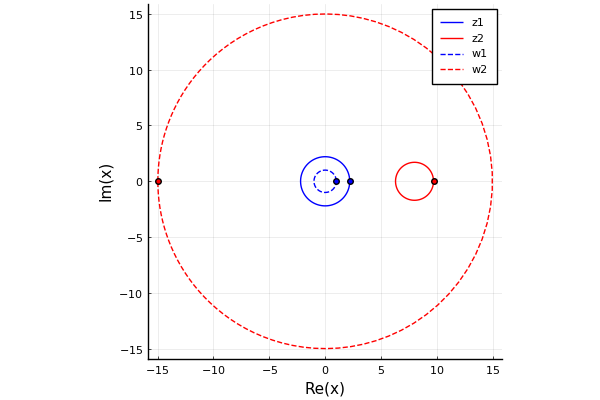

In [4]:
θ = range(0, 2π, length=n)
zc1 = @. R1*(cos(θ) + 1im*sin(θ))
zc2 = @. R2*(cos(θ) + 1im*sin(θ)) + h
T, Ti, params = find_trans(R1, R2, h)
w1 = T.(zc1)
w2 = T.(zc2)
zc1 = Ti.(w1)  # pra confirmar que a inversa está correta
zc2 = Ti.(w2)
plot(aspect_ratio=1)
plot!(zc1, color=:blue, label="z1")
scatter!(zc1[1:1], color=:blue, label="")
plot!(zc2, color=:red, label="z2")
scatter!(zc2[1:1], color=:red, label="")
plot!(w1, color=:blue, label="w1", linestyle=:dash)
scatter!(w1[1:1], color=:blue, label="")
plot!(w2, color=:red, label="w2", linestyle=:dash)
scatter!(w2[1:1], color=:red, label="")

In [5]:
# raios transformados serão a média do absoluto, pois estão
# centrados na origem e pra mascarar erro de ponto flutuante
r1 = mean(abs.(w1))
r2 = mean(abs.(w2))
# condições de contorno; descartar parte imaginária pois é
# "lixo numérico" da ordem de 1e-18
u1 = real(T(1/2))
u2 = real(T(-1/2))
# solução da equação de Laplace no anel para f1(θ) e f2(θ) = constante
ln12 = log(r1/r2)
pot(w) = u1 + (u1 - u2)*log(abs(w)/r1)/ln12

pot (generic function with 1 method)

## Resolver o problema no domínio transformado
O domínio transformado apresenta uma equação mais simples em coordenadas polars.

$$
\nabla^2 u(r, \theta) = \frac{\partial^2 u}{\partial r^2} + \frac{1}{r} \frac{\partial u}{\partial r} + \frac{1}{r^2} \frac{\partial u}{\partial \theta}
\qquad \{r1 < r < r2\}
$$

Onde $r_1$ é o raio do círculo $C_1$ transformado e $r_2$ o raio do círculo $C_2$ transformado. As condições de fronteira de Dirichlet do problema são:
$$
u_1 = u(r_1) = T(V_1)
$$

$$
u_2 = u(r_2) = T(V_2)
$$

Assumindo que os condutores são equipotenciais, isto é, $V_1$ e $V_2$ são uniformes, então a solução do problema tem forma:

$$
u(r, \theta) = u_1 + \frac{(u_1 - u_2) \log(r/r_1)}{\log(r1 /r2)}
$$

Sendo $\log \equiv \ln$ o logarítmo natural.


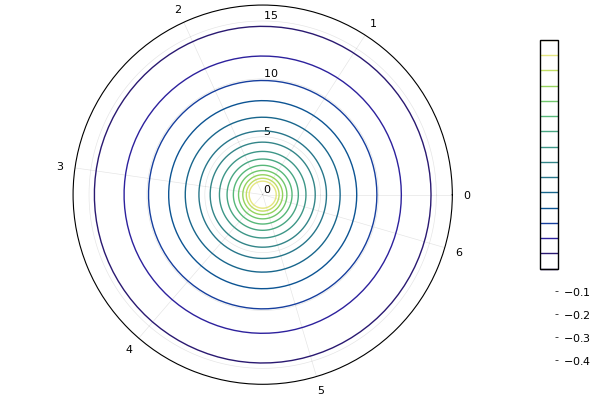

In [6]:
r = range(r1, r2, length=n);
θ = range(0, 2π, length=n);
u = pot.(r);
U = repeat(u, 1, n);

contour(θ, r, U, fill=false, proj=:polar, color=:haline)

## Solução no domínio original

O potencial $v$ num ponto $z = x + iy$ do domínio original será dado por:

$$
v(x + iy) = T^{-1}(u(|T(x + iy)|))
$$


In [7]:
p, xi1, xi2 = params
function poti(z)
    #return Ti(pot(abs(T(z))))
    num = (R1*(p + xi1 + 1) - z*(p + xi1 - 1))
    den = (R1*(p + xi2 + 1) - z*(p + xi2 - 1))
    rxy = abs(num/den)
    k = log(rxy/r1)/log(r1/r2)
    num = (1 + p - p*u1 + xi1 - u1*(1 + xi2)) - (u1 - u2)*(1 + p + xi2)*k
    den = (-1 + p + u1 - p*u1 + xi1 - u1*xi2) - (u1 - u2)*(-1 + p + xi2)*k
    return R1*num/den
end
v(x, y) = poti(x + 1im*y)

v (generic function with 1 method)

O Potencial no domínio transformado é mostrado na figura seguinte. Os valores dentro dos condutores foram mascarados, pois não fazem parte do domínio da solução.

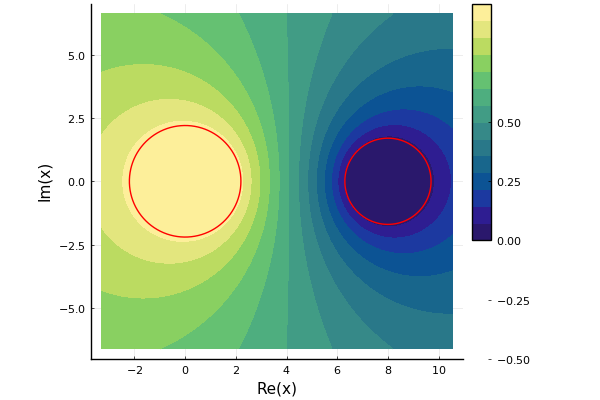

In [8]:
s = 1.5
x = range(-s*R1, h + s*R2, length=n)
y = range(-2s*R1, 2s*R1, length=n)
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(y, 1, length(x))
function vmask(x, y, mask=true)
    pot = v(x, y)
    if mask  # "mascarar" os resultados
        u1 = v1 > v2 ? v1 : v2
        u2 = v1 > v2 ? v2 : v1
        if pot > u1
            pot = u1
        elseif pot < u2
            pot = u2
        end
    end
    return pot
end
Z = map(vmask, X, Y);

contour(x, y, Z, fill=true, color=:haline, aspect_ratio=1)
plot!(zc1, color=:red, label="")
plot!(zc2, color=:red, label="")

### Condutores equivalentes
Esse campo (no espaço fora dos condutores) é o mesmo que o gerado por duas linhas de cargas pontuais nos pontos $z_1$ e $z_2$ (pontos nos quais o denominador de $v$ tende a zero).

$$
z = \frac{dw - b}{-cw + a}
$$

sendo:

$$
a = -(p + \xi_1 - 1)
$$

$$
b = R_1(p + \xi_1 + 1)
$$

$$
c = -(p + \xi_2 - 1)
$$

$$
d = R_1 (p + \xi_2 + 1)
$$

$$
w = r_1 \left( \frac{r_1}{r_2} \right)^{\pm \eta}
$$

$$
\eta = \frac{(-1 + p + u_1 - p u_1 + \xi_1 - u_1 \xi_2)}{(u_2 - u_1)(-1 + p + \xi_2)}
$$

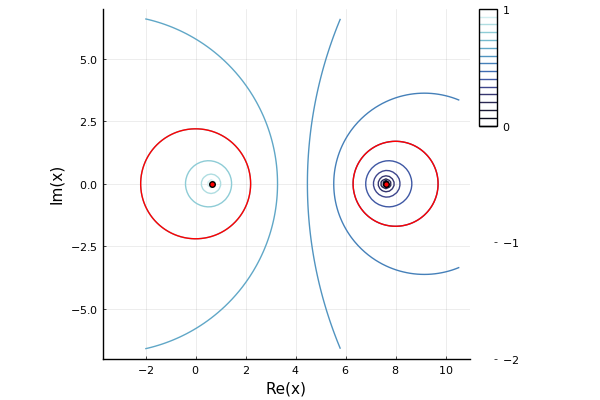

In [9]:
k = (-1 + p + u1 - p*u1 + xi1 - u1*xi2)/((u2 - u1)*(-1 + p + xi2))
a = -(p + xi1 - 1)
b = R1*(p + xi1 + 1)
c = -(p + xi2 - 1)
d = R1*(p + xi2 + 1)
w1 = r1*(r1/r2)^k
z1 = (d*w1 - b)/(-c*w1 + a)
w2 = r1*(r1/r2)^(-k)
z2 = (d*w2 - b)/(-c*w2 + a)
z1, z2

contour(x, y, (x,y) -> vmask(x, y, false), fill=false, aspect_ratio=1, color=:ice)
plot!(zc1, color=:red, label="")
plot!(zc2, color=:red, label="")
scatter!(real.([z1, z2]), imag.([z1, z2]), color=:red, label="")

Agora é necessário descobrir o valor destas cargas $q_1$ e $q_2$ . Para tal, resolvemos o seguinte sistema linear, onde $V_1$ e $V_2$ são os potenciais nas superfícies dos condutores.

$$
\begin{bmatrix}
\frac{1}{\|R_1 - z_1\|} & \frac{1}{\|R_1 - z_2\|} \\
\frac{1}{\|h - R_2 - z_1\|} & \frac{1}{\|h - R_2 - z_2\|} \\
\end{bmatrix}
\cdot
\begin{bmatrix}
q_1 \\
q_2
\end{bmatrix}
=
4\pi \epsilon
\begin{bmatrix}
V_1 \\
V_2
\end{bmatrix}
$$

In [10]:
a = [1/abs(R1 - z1)  1/abs(R1 - z2);
     1/abs(h - R2 - z1)  1/abs(h - R2 - z2)]
b = (4π*ϵ0)*[v1, v2]
q = a\b

2-element Vector{Float64}:
  1.1576186282012586e-10
 -9.946638327606126e-11

Desta forma, obtemos uma expressão analítica no domínio original utilizando
cargas equivalentes, válida para a região externa aos condutores.

$$
v(z) = \frac{1}{4 \pi \epsilon} \left( \frac{q_1}{\|z - z_1\|} + \frac{q_2}{\|z - z_2\|} \right)
$$

Para confirmar que os valores estão corretos:


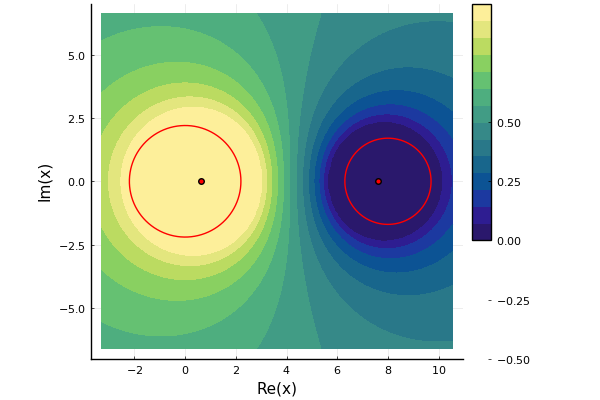

In [11]:
function valt(x, y, mask=true)
    d1 = abs(x + 1im*y - z1)
    d2 = abs(x + 1im*y - z2)
    pot = 1/(2π*ϵ0)*(q[1]/d1 + q[2]/d2)
    if mask
        u1 = v1 > v2 ? v1 : v2
        u2 = v1 > v2 ? v2 : v1
        if pot > u1
            pot = u1
        elseif pot < u2
            pot = u2
        end
    end
    return pot
end
Z2 = map(valt, X, Y);

contour(x, y, Z2, fill=true, color=:haline, aspect_ratio=1)
plot!(zc1, color=:red, label="")
plot!(zc2, color=:red, label="")
scatter!(real.([z1, z2]), imag.([z1, z2]), color=:red, label="")

Pela figura, vemos que o potencial está parecido, mas não igual ao esperado. Portanto a solução por linhas de cargas equivalentes é inválida, ou está incompleta. A hipótese é que sejam necessárias mais linhas de cargas para reconstruir o campo potencial.

**Nota-se**:
  - as cargas equivalentes ficarão mais próximas dos centros dos condutores quanto mais afastados estes estiverem;
  - as cargas tem mesmo valor em módulo, com sinal distinto, somente quando o raio dos condutores é o mesmo.

### Campo Elétrico

Podemos encontrar o campo elétrico no domínio original diretamente tomando o gradiente do campo elétrico.

$$
\vec E (x,y) = -\nabla v(x,y)
$$

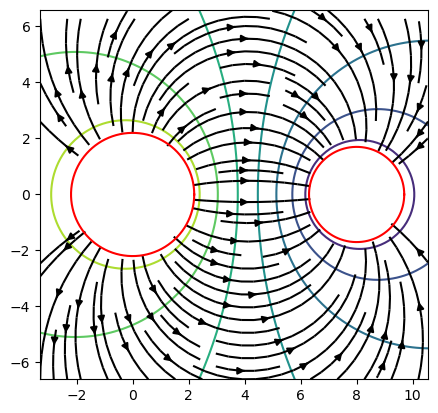

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb6ed795550>

In [12]:
# Campo elétrico por derivada numérica da função transformada
dv(x, y) = -ForwardDiff.gradient(a -> vmask(a[1], a[2]), [x, y])
Ex = Array{Float64}(undef, n, n)
Ey = Array{Float64}(undef, n, n)
for i = 1:n
    for k = 1:n
        Ex[k,i], Ey[k,i] = dv(X[k,i], Y[k,i])
    end
end
# Infelizmente, o `Plots` ainda não tem `streamplot` implementado.
# Portanto, vamos usar o `PyPlot`, que o tem.
fig = PyPlot.figure(1)
ax = PyPlot.gca()
ax.set_aspect(1)
ax.contour(X, Y, Z, color=:plasma)
ax.streamplot(X, Y, Ex, Ey, color=:black)
ax.plot(real.(zc1), imag.(zc1), color=:red)
ax.plot(real.(zc2), imag.(zc2), color=:red)

## Considerações Finais
Para uso em casos práticos, devese-considerar o caso de múltiplos condutores e, a partir disto, a presença de múltiplos meios. Desta forma, poderemos obter a solução para condutores enterrados, ou linhas de transmissão aéreas.

**Hipótese a testar:** o caso de múltiplos condutores pode ser solucionado através da sobreposição das soluções de cada par de condutores.

É interessante encontrar a capacitância deste sistema. Isto seria mais fácil se pudermos determinar o conjunto de cargas equivalentes.
